#Previsão Água Bruta com ARIMA Univariada

##Montagem Drive Virtual

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


##Tratamento dos Dados

In [0]:
dados = pd.read_excel('gdrive/My Drive/Material BSI/LM/Projeto_LM/Dados2.xlsx', sheet_name='vazoes_agua_hora')

#Padronização das datas
dados['Data'] = pd.to_datetime(dados['Data'])
dados['Data_dia'] = dados['Data'].map(lambda x: x.strftime('%Y-%m-%d'))

#Tratamento Geral
dados['agua_bruta_m3/h'] = dados['agua_bruta_m3/h'].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float).dropna()
dados['agua_vapor_m3/h'] = dados['agua_vapor_m3/h'].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float).dropna()
dados['agua_torre_resf_1_m3/h'] = dados['agua_torre_resf_1_m3/h'].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float).dropna()
dados['agua_torre_resf_2_m3/h'] = dados['agua_torre_resf_2_m3/h'].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float).dropna()

#Agrupamento dos dados de horários para diários
dados_diarios_totalizados = dados.groupby('Data_dia')

#Totalização das vazões horárias em VOLUME DIÁRIO
dados_diarios_totalizados = dados_diarios_totalizados.aggregate(np.sum)
dados_diarios_totalizados = dados_diarios_totalizados.rename(columns={'agua_bruta_m3/h': 'agua_bruta_m3', 'agua_vapor_m3/h': 'agua_vapor_m3', 'agua_torre_resf_1_m3/h': 'agua_torre_resf_1_m3', 'agua_torre_resf_2_m3/h': 'agua_torre_resf_1_m3'})

#Criação CSV
dados_diarios_totalizados.to_csv('gdrive/My Drive/Material BSI/LM/Projeto_LM/agua_totalizada.csv', encoding='utf-8')

#Transformação dos tipos das datas para DATETIME
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d') 
data = pd.read_csv('gdrive/My Drive/Material BSI/LM/Projeto_LM/agua_totalizada.csv', parse_dates=[0], index_col='Data_dia',date_parser=dateparse)

#Isolando apenas a série temporal da água bruta
ts_agua_bruta = data['agua_bruta_m3'] 

##Gráfico Série Temporal Volume de Água Bruta Diária

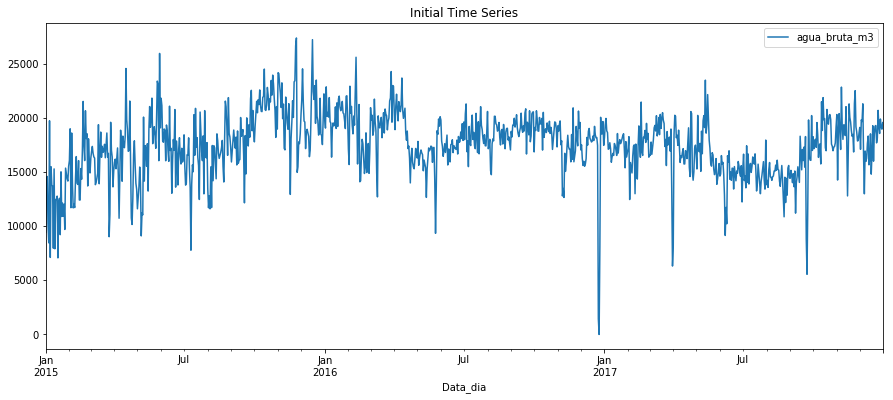

In [33]:
import warnings
from matplotlib import pyplot
warnings.filterwarnings("ignore")
ts_agua_bruta.plot()
pyplot.title('Initial Time Series')
pyplot.legend(['agua_bruta_m3'])
pyplot.show()

##Teste de Dick-Fuller (verifica estacionariedade)

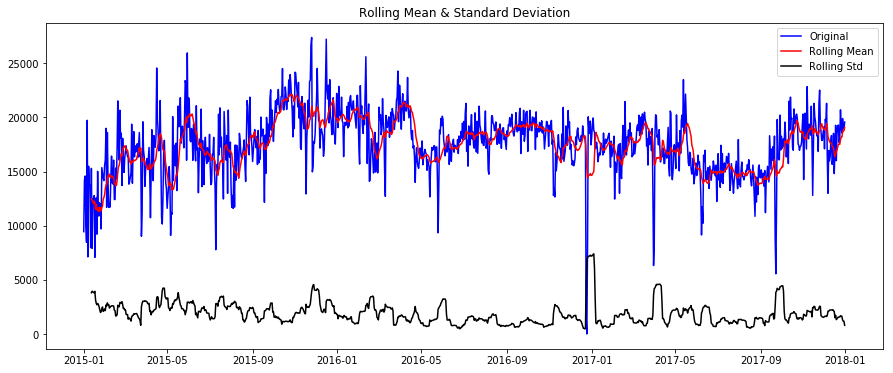

Results of Dickey-Fuller Test:
Test Statistic                   -4.916634
p-value                           0.000032
#Lags Used                        9.000000
Number of Observations Used    1086.000000
Critical Value (1%)              -3.436386
Critical Value (5%)              -2.864205
Critical Value (10%)             -2.568189
dtype: float64


In [4]:
#Criação da função
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#Executando o teste
test_stationarity(ts_agua_bruta)

##Validation Dataset

In [6]:
#Separando dados para validação final do modelo (Utilizado 10% dos dados para validação)
import warnings
split_point = len(ts_agua_bruta) - 100
dataset_agua_bruta, validation_agua_bruta = ts_agua_bruta[0:split_point], ts_agua_bruta[split_point:]
print('Dataset %d, Validation %d' % (len(dataset_agua_bruta), len(validation_agua_bruta)))
dataset_agua_bruta.to_csv('gdrive/My Drive/Material BSI/LM/Projeto_LM/dataset_agua_bruta.csv')
validation_agua_bruta.to_csv('gdrive/My Drive/Material BSI/LM/Projeto_LM/validation_agua_bruta.csv')
warnings.filterwarnings("ignore")

Dataset 996, Validation 100


##Persistence

In [7]:
import warnings
from pandas import Series
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
series = Series.from_csv('gdrive/My Drive/Material BSI/LM/Projeto_LM/dataset_agua_bruta.csv')
warnings.filterwarnings("ignore")
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	yhat = history[-1]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=15406.484, Expected=12662
>Predicted=12661.582, Expected=15259
>Predicted=15258.535, Expected=16282
>Predicted=16282.283, Expected=17226
>Predicted=17226.482, Expected=16968
>Predicted=16968.191, Expected=17096
>Predicted=17095.562, Expected=17400
>Predicted=17399.641, Expected=17341
>Predicted=17340.953, Expected=15897
>Predicted=15896.535, Expected=17247
>Predicted=17247.393, Expected=17278
>Predicted=17277.805, Expected=14220
>Predicted=14219.565, Expected=9341
>Predicted=9341.130, Expected=13704
>Predicted=13703.662, Expected=18818
>Predicted=18817.744, Expected=18485
>Predicted=18485.029, Expected=19901
>Predicted=19900.799, Expected=19241
>Predicted=19241.168, Expected=20112
>Predicted=20112.486, Expected=19808
>Predicted=19807.529, Expected=17864
>Predicted=17863.723, Expected=17380
>Predicted=17379.713, Expected=16454
>Predicted=16453.902, Expected=16955
>Predicted=16955.283, Expected=17612
>Predicted=17611.832, Expected=16811
>Predicted=16811.496, Expected=17657
>Pr

##Summary Statistics

In [8]:
dataset_agua_bruta.describe()

count      996.000000
mean     17396.282639
std       2999.889769
min          0.000000
25%      15664.075989
50%      17510.395401
75%      19218.202591
max      27387.433533
Name: agua_bruta_m3, dtype: float64

##Line Plot

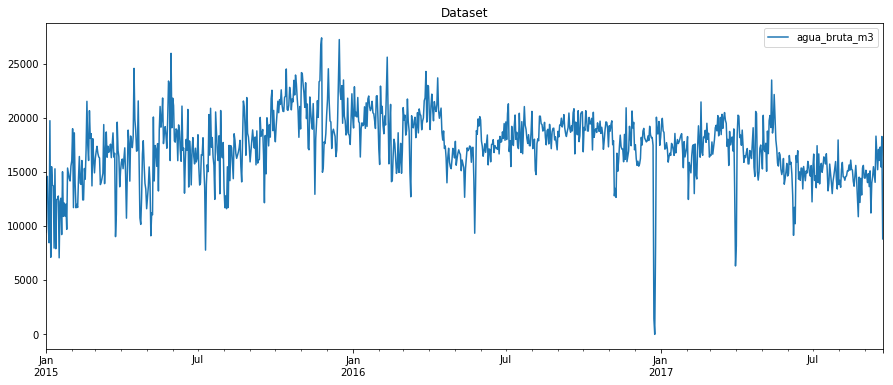

In [34]:
import warnings
from pandas import Series
from matplotlib import pyplot
series = Series.from_csv('gdrive/My Drive/Material BSI/LM/Projeto_LM/dataset_agua_bruta.csv')
warnings.filterwarnings("ignore")
series.plot()
pyplot.title('Dataset')
pyplot.legend(['agua_bruta_m3'])
pyplot.show()

##Density Plot

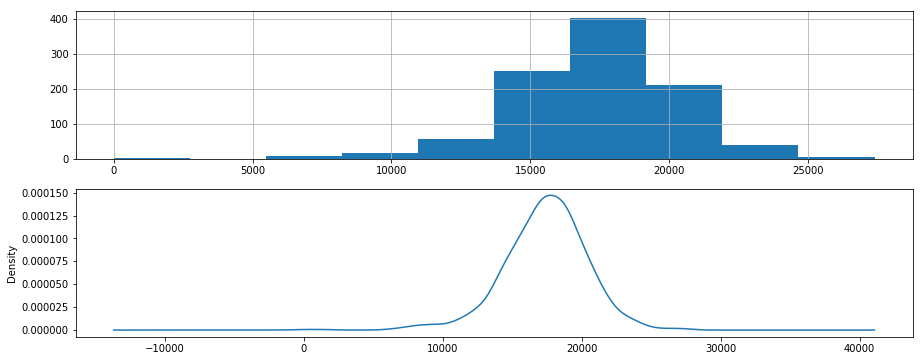

In [10]:
import warnings
from pandas import Series
from matplotlib import pyplot
series = Series.from_csv('gdrive/My Drive/Material BSI/LM/Projeto_LM/dataset_agua_bruta.csv')
warnings.filterwarnings("ignore")
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

##ARIMA Models

###Manually Configured ARIMA

In [11]:
import warnings
from pandas import Series
from statsmodels.tsa.stattools import adfuller

series = Series.from_csv('gdrive/My Drive/Material BSI/LM/Projeto_LM/dataset_agua_bruta.csv')
X = series.values
warnings.filterwarnings("ignore")

# check if stationary without difference
not_stationary = X
# not_stationary.index = series.index[1:]
result1 = adfuller(not_stationary)
print('Difference Not Applicated')
print('ADF Statistic: %f' % result1[0])
print('p-value: %f' % result1[1])
print('Critical Values:')
for key, value in result1[4].items():
	print('\t%s: %.3f' % (key, value))

Difference Not Applicated
ADF Statistic: -4.137338
p-value: 0.000840
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


###ACF and PACF plots 

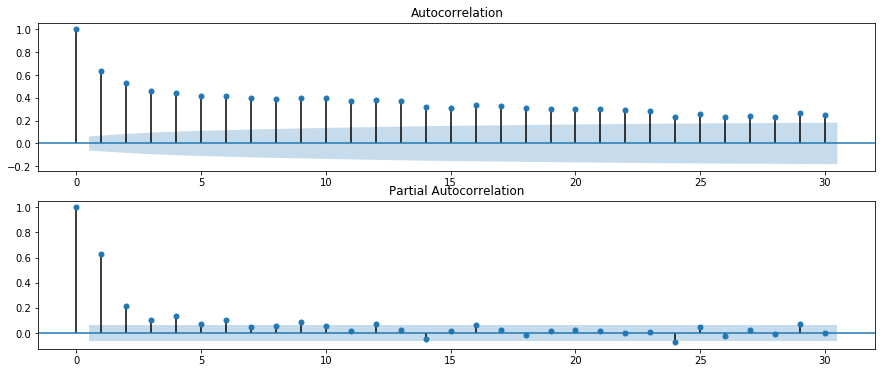

In [12]:
import warnings
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
series = Series.from_csv('gdrive/My Drive/Material BSI/LM/Projeto_LM/dataset_agua_bruta.csv')
warnings.filterwarnings("ignore")
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, ax=pyplot.gca())
pyplot.show()

###Model simplified to ARIMA(1,0,2)

In [13]:
import warnings
from pandas import Series
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
# load data
series = Series.from_csv('gdrive/My Drive/Material BSI/LM/Projeto_LM/dataset_agua_bruta.csv')
warnings.filterwarnings("ignore")
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(1,0,2))
	model_fit = model.fit(disp=0)
	yhat = model_fit.forecast()[0]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=16034.132, Expected=12662
>Predicted=15023.648, Expected=15259
>Predicted=15504.659, Expected=16282
>Predicted=15781.478, Expected=17226
>Predicted=16221.576, Expected=16968
>Predicted=16346.282, Expected=17096
>Predicted=16543.748, Expected=17400
>Predicted=16778.550, Expected=17341
>Predicted=16887.968, Expected=15897
>Predicted=16507.933, Expected=17247
>Predicted=16875.738, Expected=17278
>Predicted=16950.714, Expected=14220
>Predicted=16005.473, Expected=9341
>Predicted=14076.722, Expected=13704
>Predicted=14757.581, Expected=18818
>Predicted=16248.769, Expected=18485
>Predicted=16567.563, Expected=19901
>Predicted=17467.441, Expected=19241
>Predicted=17684.109, Expected=20112
>Predicted=18324.286, Expected=19808
>Predicted=18539.088, Expected=17864
>Predicted=18105.451, Expected=17380
>Predicted=17908.602, Expected=16454
>Predicted=17473.201, Expected=16955
>Predicted=17464.907, Expected=17612
>Predicted=17574.527, Expected=16811
>Predicted=17285.874, Expected=17657
>P

###Grid Search ARIMA Hyperparameters

In [15]:
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# load dataset
series = Series.from_csv('gdrive/My Drive/Material BSI/LM/Projeto_LM/dataset_agua_bruta.csv')
warnings.filterwarnings("ignore")
# evaluate parameters
p_values = range(0,3)
d_values = [0]
q_values = range(0,3)
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=2539.363
ARIMA(0, 0, 1) MSE=2127.427
ARIMA(0, 0, 2) MSE=2004.348
ARIMA(1, 0, 0) MSE=1932.056
ARIMA(1, 0, 1) MSE=2005.120
ARIMA(1, 0, 2) MSE=1950.233
ARIMA(2, 0, 0) MSE=1965.480
ARIMA(2, 0, 1) MSE=1923.175
ARIMA(2, 0, 2) MSE=1922.508
Best ARIMA(2, 0, 2) MSE=1922.508


###Finalize Model

In [0]:
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
 
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
 
ARIMA.__getnewargs__ = __getnewargs__
 
# load data
series = Series.from_csv('gdrive/My Drive/Material BSI/LM/Projeto_LM/dataset_agua_bruta.csv')
warnings.filterwarnings("ignore")
# prepare data
X = series.values
X = X.astype('float32')
# fit model
model_agua_bruta = ARIMA(X, order=(1,0,0))
model_agua_bruta_fit = model_agua_bruta.fit(disp=0)
# save model
model_agua_bruta_fit.save('model_agua_bruta.pkl')

###Make a single prediction

In [23]:
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMAResults

model_agua_bruta_fit = ARIMAResults.load('model_agua_bruta.pkl')
yhat = model_agua_bruta_fit.forecast()[0]

validation = Series.from_csv('gdrive/My Drive/Material BSI/LM/Projeto_LM/validation_agua_bruta.csv')
warnings.filterwarnings("ignore")
y = validation.values.astype('float32')

print('Predicted: %.3f' % yhat)
print('Expected: ',y[0])

Predicted: 11892.699
Expected:  5558.0356


###Validate Model

>Predicted=11892.699, Expected=5558
>Predicted=9727.159, Expected=11973
>Predicted=13891.844, Expected=19813
>Predicted=18933.246, Expected=16428
>Predicted=16766.079, Expected=16108
>Predicted=16561.190, Expected=16083
>Predicted=16544.780, Expected=20218
>Predicted=19190.165, Expected=16998
>Predicted=17130.802, Expected=18261
>Predicted=17936.096, Expected=17157
>Predicted=17233.348, Expected=17863
>Predicted=17683.930, Expected=18028
>Predicted=17788.397, Expected=17286
>Predicted=17316.816, Expected=19574
>Predicted=18777.211, Expected=18443
>Predicted=18055.978, Expected=16357
>Predicted=16724.741, Expected=17448
>Predicted=17420.295, Expected=17606
>Predicted=17520.391, Expected=15748
>Predicted=16334.844, Expected=21497
>Predicted=20000.610, Expected=18840
>Predicted=18308.839, Expected=21877
>Predicted=20246.209, Expected=19828
>Predicted=18940.561, Expected=19942
>Predicted=19014.327, Expected=17241
>Predicted=17292.770, Expected=16970
>Predicted=17120.152, Expected=20784
>Pr

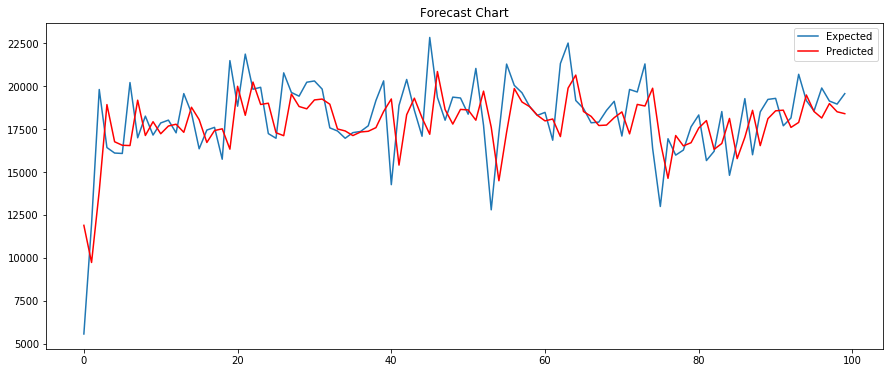

In [27]:
import warnings
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error
from math import sqrt

# load and prepare datasets
dataset = Series.from_csv('gdrive/My Drive/Material BSI/LM/Projeto_LM/dataset_agua_bruta.csv')
warnings.filterwarnings("ignore")
X = dataset.values.astype('float32')
history = [x for x in X]
validation = Series.from_csv('gdrive/My Drive/Material BSI/LM/Projeto_LM/validation_agua_bruta.csv')
warnings.filterwarnings("ignore")
y = validation.values.astype('float32')

# load model
model_agua_bruta_fit = ARIMAResults.load('model_agua_bruta.pkl')

# make first prediction
predictions = list()
yhat = model_agua_bruta_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))

# rolling forecasts
for i in range(1, len(y)):

  # predict
	model_agua_bruta = ARIMA(history, order=(1,0,0))
	model_agua_bruta_fit = model_agua_bruta.fit(disp=0)
	yhat = model_agua_bruta_fit.forecast()[0]
	
  # invert transformed prediction
	predictions.append(yhat)
	
  # observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.legend(['Expected','Predicted'])
pyplot.title('Forecast Chart')
pyplot.show()